In [10]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from importlib import reload
sys.path.append(os.getcwd()+"/../GEF")
import GEFClassic
reload(GEFClassic)
from GEFClassic import GEF
import ModeByModeClassic
reload(ModeByModeClassic)
from ModeByModeClassic import ModeByMode
from scipy.interpolate import CubicSpline

In [11]:
#Set coupling Constant
beta=10
#Set path to the directory where the GEF results are stored
path = os.getcwd()
name = path+f"/../Out/GEF_Beta{beta}.0_SENone_M6.16_Bdr.dat"
#Set up initial conditions for the GEF system (I plan to streamline this at some point)
alpha = 0.
Mpl = 1.
M = 6.16e-6*Mpl
phi0 = 15.55*Mpl
dphidt0 = -np.sqrt(2/3)*M*Mpl
ini = {"phi":phi0, "dphi":dphidt0}
ntr = 150
H = GEF(beta, Mpl, ini, M, ntr, approx=True)

In [12]:
H.LoadData(name)
MbM = ModeByMode(H)

3.915915816822987e-05
[61.00191385]


In [13]:
ks = np.exp(np.linspace(np.log(MbM.mink), np.log(MbM.maxk), 1000))
ks, tstart = MbM.InitialKTN(ks, mode="k")

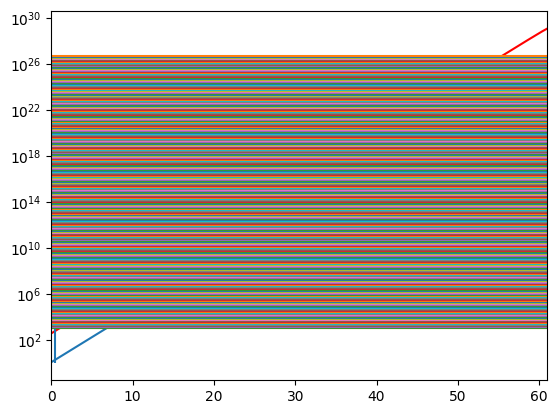

In [14]:
mink = MbM.mink
plt.plot(H.vals["N"], H.vals["kh"])
plt.plot(H.vals["N"], 10**(5/2)*H.vals["kh"], "r")
plt.plot(H.vals["N"], mink*np.ones(H.vals["N"].shape))
plt.vlines(0.5, 1, 1e4)
for i, k in enumerate(ks):
    plt.plot(H.vals["N"], np.ones(H.vals["N"].shape)*k)
plt.xlim(0, 61)
#plt.ylim(1, 1e4)
plt.yscale("log")

In [15]:
Neval = np.arange(H.EndOfInflation()[0], 5, -0.1)[::-1]
#print(Neval)
teval = CubicSpline(H.vals["N"], H.vals["t"])(Neval)

3.915915816822987e-05
[61.00191385]


In [21]:
Ap = []
dAp = []
Am = []
dAm = []
for i, k in enumerate(ks):
    A1, A2, A3, A4 = MbM.ComputeMode(k, tstart[i], teval=teval, rtol=1e-5)
    Ap.append(A1)
    Am.append(A3)
    dAp.append(A2)
    dAm.append(A4)
Ap = np.array(Ap)
Am = np.array(Am)
dAp = np.array(dAp)
dAm = np.array(dAm)

In [22]:
print(Am.shape)
khN = CubicSpline(H.vals["N"], H.vals["kh"])

(500, 561)


In [23]:
EMode = []
BMode = []
GMode = []
#print(Ap[60,:])
#print(ts.size)
for i, t in enumerate(teval):
    Etmp, Btmp, Gtmp = MbM.ComputeEBGnMode(Ap[:,i], Am[:,i], dAp[:,i], dAm[:,i], t, ks)
    EMode.append(Etmp)
    BMode.append(Btmp)
    GMode.append(Gtmp)
    
EMode1 = np.array(EMode)
BMode1 = np.array(BMode)
GMode1 = np.array(GMode)

3.915915816822987e-05
[61.00191385]


/tmp/ipykernel_84451/186203748.py:9: RuntimeWarning: divide by zero encountered in divide
  errE = abs(ER - EMode1)/EMode1
/tmp/ipykernel_84451/186203748.py:11: RuntimeWarning: divide by zero encountered in divide
  errB = abs(BR - BMode1)/BMode1
/tmp/ipykernel_84451/186203748.py:13: RuntimeWarning: divide by zero encountered in divide
  errG = abs(GR - GMode1)/GMode1


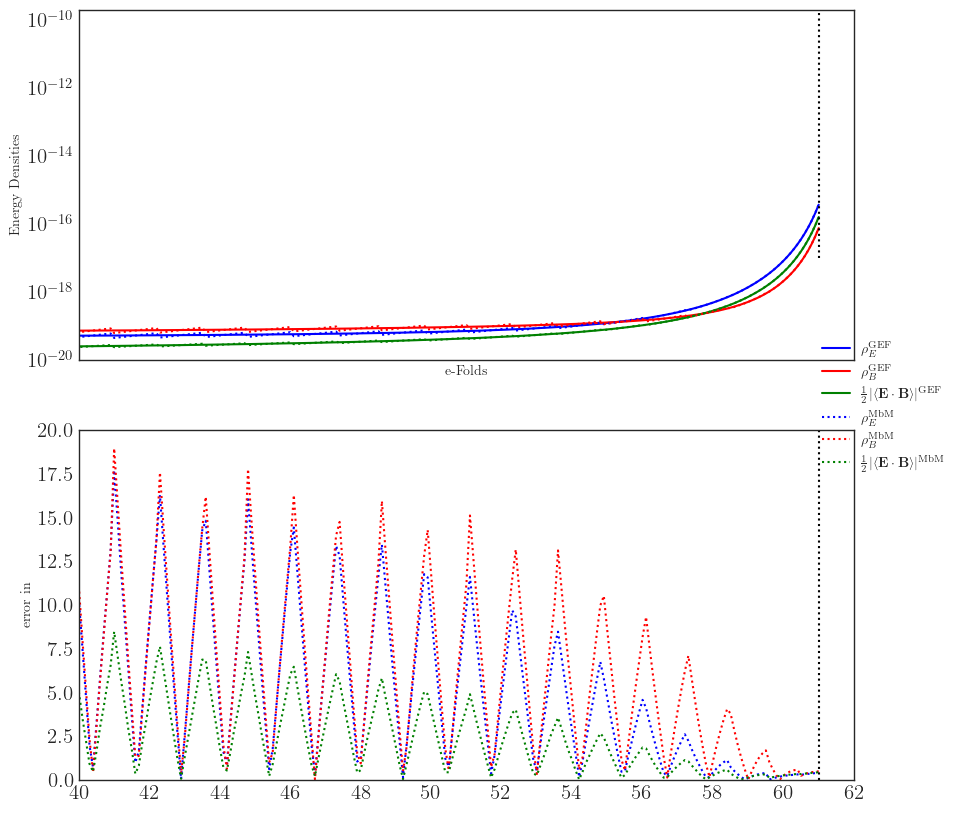

In [24]:
fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True)
ER = CubicSpline(H.vals["N"], H.vals["E"])(Neval)
BR = CubicSpline(H.vals["N"], H.vals["B"])(Neval)
GR = CubicSpline(H.vals["N"], H.vals["G"])(Neval)
NR = Neval
Nend = H.EndOfInflation()[0]
omega = H.H0
rhoE = 0.5*ER*omega**4
errE = abs(ER - EMode1)/EMode1
rhoB = 0.5*BR*omega**4
errB = abs(BR - BMode1)/BMode1
rhoG = 0.5*abs(GR)*omega**4
errG = abs(GR - GMode1)/GMode1

xticks = np.arange(36, 57, 2)
xticksmin = np.arange(35, 58, 2)
xticks = np.arange(40, 64, 2)
xticksmin = np.arange(41, 63, 2)
yticks = 10**(-1.*np.arange(14, 17))

ax[0].plot(NR, rhoE, "b", label=r"$\rho_E^{\mathrm{GEF}}$")
ax[0].plot(NR, rhoB, "r", label=r"$\rho_B^{\mathrm{GEF}}$")
ax[0].plot(NR, rhoG, "g", label=r"$\frac{1}{2} |\langle \mathbf{E} \cdot \mathbf{B} \rangle|^{\mathrm{GEF}}$")
ax[0].plot(NR, 0.5*EMode1*omega**4, "b:", label=r"$\rho_E^{\mathrm{MbM}}$")
ax[0].plot(NR, 0.5*BMode1*omega**4, "r:", label=r"$\rho_B^{\mathrm{MbM}}$")
ax[0].plot(NR, 0.5*abs(GMode1)*omega**4, "g:", label=r"$\frac{1}{2} |\langle \mathbf{E} \cdot \mathbf{B} \rangle|^{\mathrm{MbM}}$")
ax[0].vlines(Nend, ymin=1e-17, ymax=2e-10, colors="k", linestyles="dotted")
ax[0].set_ylim(1e-20, 2e-10)
ax[0].set_xlim(40, max(Neval))#Nend+1)

ax[0].set_xticks(xticks)
ax[0].set_xticks(xticksmin, minor=True)
ax[0].set_yticks(yticks)
ax[0].set_ylabel("Energy Densities")
ax[1].set_ylabel("error in %")
ax[0].set_xlabel("e-Folds")
ax[0].set_xlabel("e-Folds")
ax[0].set_yscale("log")
ax[1].plot(NR, abs(errE*100), "b:")
ax[1].plot(NR, abs(errB*100), "r:")
ax[1].plot(NR, abs(errG*100), "g:")
ax[1].set_ylim(0.,20)
ax[1].vlines(Nend, ymin=0, ymax=50, colors="k", linestyles="dotted")
#ax[1].set_yticks(np.arange(0,5,1))
lines_labels = [ax[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=5)